## Django로 크롤링한 데이터 저장하기

데이터를 체계적으로 관리하려면 DB가 필요하고, 이러한 DB를 만들고 관리하는 방법이
여라기지가 있지만 이번에는 Python웹 프레임워크인 django의 Database ORM을 이용해 DB를 만들고 데이터 저장을 해보자.

### Django 프로젝트 만들기
우선 크롤링 한 데이터를 저장할 Django 프로젝트와 앱을 만들고, Model을 통해 DB를 만들어야합니다.

In [1]:
# Django 설치
!pip install django

In [3]:
from IPython.display import Image

Image("")
![이미지이름](파일경로/파일명.확장자명)

NameError: name 'django' is not defined

## Django Start Project | 프로젝트 만들기

Django 설치 이후 anaconda prompt를 실행 시키고 `django-admin`이라는 명령어로 장고 프로젝트를 생성

![프로젝트 만들기](websaver/img/캡처.png)
> 성공적으로 생길 경우 어떤한 반응도 나타나지 않습니다.
> 폴더에 들어가보면 websaver 생성된 것 확인
> cd websaver로 websaver 폴더 안으로 진입

![websaver폴더](websaver/img/캡처1.png)



## Django Start App | 장고 앱 만들기
Django는 프로젝트와 그 안의 `앱`으로 관리됩니다. 이 `앱`은 하나의 기능을 담당하는 단위로 보시면 됩니다.

앱은 `manage.py` 파일을 통해 `startapp`이라는 명령어로 생성 가능합니다.
`parsed_data`라는 이름의 앱을 만들어 보겠습니다.

```python
python manage.py startapp parsed_data
```

![Django Start App](websaver/img/캡처2.png)

> manage.py 파일이 있는 곳에서 실행합니다. django가 설치된 가상환경에 진입해 있는지 꼭 확인하세요!

이제 이 앱을 Django가 관리하도록 `websaver`폴더 안의 `settings.py`파일의 `INSTALLED_APPS`에 추가해줘야 합니다.

```python
## websaver/settings.py
...
INSTALLED_APPS = [
    'django.contrib.admin',
    'django.contrib.auth',
    'django.contrib.contenttypes',
    'django.contrib.sessions',
    'django.contrib.messages',
    'django.contrib.staticfiles',
    'parsed_data', ## 앱을 추가해 줍시다.
]
...
```
![Installed_apps](websaver/img/캡처4.png)


## Django First Migration | 첫 마이그레이션
django는 `python manage.py migrate` 이라는 명령어로 DB를 migrate합니다
```python
python manage.py migrate
```

위 명령어를 입력하면 아래와 같이 Django에서 사용하는 기본적인 DB가 생성됩니다.
![First Migration](websaver/img/캡처5.png)

## parsed_data App Model | parsed_data 앱 모델 만들기
이제 DB구조를 관리해주는 `Model`을 만들어 줘야 합니다.

Django에서 모델은 앱 단위로 만들어지고 구성됩니다. 따라서 앞서 만들어준 `parsed_data` 앱 안의 `models.py`파일을 수정해줘야 합니다.

```python
## parsed_data/models.py
from django.db import models

# Create your models here.

class NavpayData(models.Model):
	title = models.CharField(max_length=200)
	link = models.URLField()
    
```

이와 같이 만들어주면 `title`은 200글자 제한의 CharField로, `link`는 URLField로 지정됩니다.

![App Model](websaver/img/캡처6.png)

## parsed_data App Makemigrations & Migrate | 앱 DB 반영하기

이제 해야 할 일은 Django가 모델을 관리하도록 하려면 `makemigrations`를 통해 DB의 변경 정보를 정리하고, `migrate`를 통해 실제 DB에 반영하는 과정을 진행해야 합니다.
> django가 설치된 가상환경에서 실행하도록 합시다. 명령어의 실행 위치는 manage.py 파일이 있는 곳입니다.

```python
python manage.py makemigrations parsed_data
python manage.py migrate parsed_data
```

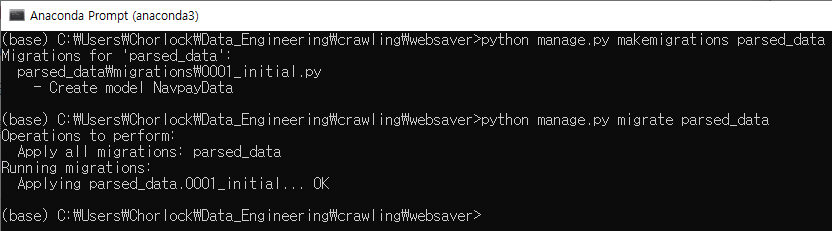

## 크롤링 함수 만들기

`parser.py`파일을 수정하여 `네이버 페이`에서 데이터를 가져오겠습니다.

이번 파일은 `manage.py`가 있는 위치에 `parser.py`라는 이름으로 저장해보겠습니다.

```python
## parser.py
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup as bs
import pyperclip


## setup Driver|Chrome : 크롬드라이버를 사용하는 driver 생성
driver = webdriver.Chrome('C:/Users/Chorlock/Downloads/chromedriver_win32/chromedriver')
# 암묵적으로 웹 자원을 (최대) 3초 기다리기
driver.implicitly_wait(3)

## Login
driver.get('https://nid.naver.com/nidlogin.login?mode=form&url=https%3A%2F%2Fwww.naver.com')
# 로그인 자동 입력 방지를 위해 pyperclip 복사 붙여넣기 사용
pyperclip.copy('아이디')
driver.find_element_by_name('id').send_keys(Keys.CONTROL, 'v')
pyperclip.copy('비밀번호')
driver.find_element_by_name('pw').send_keys(Keys.CONTROL, 'v')
driver.find_element_by_xpath('//*[@id="log.login"]').click() # 버튼 클릭
driver.implicitly_wait(3)

# Naver 페이 들어가기
# 이게 있으면 넘어가고 없으면 안넘어감 why???
driver.find_element_by_link_text('다음').click() 

# 바로 넘어가지지 않음
driver.get('https://order.pay.naver.com/home') # 네이버 페이
html = driver.page_source ## 페이지 elements 모두 가져오기
soup = bs(html, 'html.parser') # BeautifulSoup사용하기
notices = soup.select('div.goods_item > div > a > p')

for n in notices:
    print(n.text.strip())

```
이전의 `네이버 페이`에서 데이터를 가져오는 파일을 `parse_Navpay`라는 함수로 만들고, {'구매물품 이름': '구매물품 링크'}로 이루어진 딕셔너리를 반환하도록 만들어 봅시다.

```python
## parser.py
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup as bs
import pyperclip


def parse_Navpay():
    driver = webdriver.Chrome('C:/Users/Chorlock/Downloads/chromedriver_win32/chromedriver')
    # 암묵적으로 웹 자원을 (최대) 3초 기다리기
    driver.implicitly_wait(3)

    ## Login
    driver.get('https://nid.naver.com/nidlogin.login?mode=form&url=https%3A%2F%2Fwww.naver.com')
    # 로그인 자동 입력 방지를 위해 pyperclip 복사 붙여넣기 사용
    pyperclip.copy('아이디')
    driver.find_element_by_name('id').send_keys(Keys.CONTROL, 'v')
    pyperclip.copy('비밀번호')
    driver.find_element_by_name('pw').send_keys(Keys.CONTROL, 'v')
    driver.find_element_by_xpath('//*[@id="log.login"]').click() # 버튼 클릭
    driver.implicitly_wait(3)

    # Naver 페이 들어가기
    # 이게 있으면 넘어가고 없으면 안넘어감 why???
    driver.find_element_by_link_text('다음').click() 

    # 바로 넘어가지지 않음
    driver.get('https://order.pay.naver.com/home') # 네이버 페이
    html = driver.page_source ## 페이지 elements 모두 가져오기
    soup = bs(html, 'html.parser') # BeautifulSoup사용하기
    notices = soup.select('div.goods_item > div > a > p')
    link = soup.select('div.goods_item > div > a')

    data = {}


    for n, l in zip(notices, link):
        data[n.text.strip()] = l.get('href')

    return data
```

이제 `parse_Navpay`라는 함수를 다른 파일에서 import해 사용할 수 있습니다.

하지만 현재 `parse_Navpay`함수는 Django에 저장하는 기능을 갖고 있지 않습니다. 따라서 약간 더 추가를 해줘야 합니다.

## Django 환경 불러오기

```python
## parser.py
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup as bs
import pyperclip

## 아래 4줄을 추가해 줍니다.
import os
## Python이 실행될 때 DJANGO_SETTINGS_MODULE이라는 환경 변수에 현재 프로젝트의 settings.py파일 경로를 등록합니다.
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "websaver.settings")
## 이제 장고를 가져와 장고 프로젝트를 사용할 수 있도록 환경을 만듭니다.
import django
django.setup()

def parse_Navpay():
    driver = webdriver.Chrome('C:/Users/Chorlock/Downloads/chromedriver_win32/chromedriver')
    # 암묵적으로 웹 자원을 (최대) 3초 기다리기
    driver.implicitly_wait(3)

    ## Login
    driver.get('https://nid.naver.com/nidlogin.login?mode=form&url=https%3A%2F%2Fwww.naver.com')
    # 로그인 자동 입력 방지를 위해 pyperclip 복사 붙여넣기 사용
    pyperclip.copy('아이디')
    driver.find_element_by_name('id').send_keys(Keys.CONTROL, 'v')
    pyperclip.copy('비밀번호')
    driver.find_element_by_name('pw').send_keys(Keys.CONTROL, 'v')
    driver.find_element_by_xpath('//*[@id="log.login"]').click() # 버튼 클릭
    driver.implicitly_wait(3)

    # Naver 페이 들어가기
    # 이게 있으면 넘어가고 없으면 안넘어감 why???
    driver.find_element_by_link_text('다음').click() 

    # 바로 넘어가지지 않음
    driver.get('https://order.pay.naver.com/home') # 네이버 페이
    html = driver.page_source ## 페이지 elements 모두 가져오기
    soup = bs(html, 'html.parser') # BeautifulSoup사용하기
    notices = soup.select('div.goods_item > div > a > p')
    link = soup.select('div.goods_item > div > a')

    data = {}


    for n, l in zip(notices, link):
        data[n.text.strip()] = l.get('href')

    return data
```

위 코드에서 아래 4줄을 추가해 줄 경우, 이 파일을 단독으로 실행하더라도 마치 `manage.py`을 통해 django를 구동한 것과 같이 django환경을 사용할 수 있게 됩니다.

## Django ORM으로 데이터 저장하기
```python
import os
os.environ.setdefault("DAJNGO_SETTINGS_MODULE", "websaver.settings")
import django
dango.setup()
```
> `python manage.py shell`을 실행하는 것과 비슷한 방법입니다.

이제 models에서 우리가 만든 `NavpayData`를 import해 봅시다.

```python
## parser.py
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup as bs
import pyperclip

## 아래 4줄을 추가해 줍니다.
import os
## Python이 실행될 때 DJANGO_SETTINGS_MODULE이라는 환경 변수에 현재 프로젝트의 settings.py파일 경로를 등록합니다.
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "websaver.settings")
## 이제 장고를 가져와 장고 프로젝트를 사용할 수 있도록 환경을 만듭니다.
import django
django.setup()
## NavpayData를 import해옵니다
from parsed_data.models import NavpayData

def parse_Navpay():
    driver = webdriver.Chrome('C:/Users/Chorlock/Downloads/chromedriver_win32/chromedriver')
    # 암묵적으로 웹 자원을 (최대) 3초 기다리기
    driver.implicitly_wait(3)

    ## Login
    driver.get('https://nid.naver.com/nidlogin.login?mode=form&url=https%3A%2F%2Fwww.naver.com')
    # 로그인 자동 입력 방지를 위해 pyperclip 복사 붙여넣기 사용
    pyperclip.copy('아이디')
    driver.find_element_by_name('id').send_keys(Keys.CONTROL, 'v')
    pyperclip.copy('비밀번호')
    driver.find_element_by_name('pw').send_keys(Keys.CONTROL, 'v')
    driver.find_element_by_xpath('//*[@id="log.login"]').click() # 버튼 클릭
    driver.implicitly_wait(3)

    # Naver 페이 들어가기
    # 이게 있으면 넘어가고 없으면 안넘어감 why???
    driver.find_element_by_link_text('다음').click() 

    # 바로 넘어가지지 않음
    driver.get('https://order.pay.naver.com/home') # 네이버 페이
    html = driver.page_source ## 페이지 elements 모두 가져오기
    soup = bs(html, 'html.parser') # BeautifulSoup사용하기
    notices = soup.select('div.goods_item > div > a')
    notices = soup.select('div.goods_item > div > a > p')
    link = soup.select('div.goods_item > div > a')

    data = {}


    for n, l in zip(notices, link):
        data[n.text.strip()] = l.get('href')

    return data

## 이 명령어는 이 파일이 import가 아닌 python에서 직접 실행할 경우에만 아래 코드가 실행됩니다
if __name__ == '__main__':
    navpay_data_dict = parse_Navpay()
    for t, l in navpay_data_dict.items():
        NavpayData(title=t, link=l).save()
```
위와 같이 `parser.py`를 수정한 후 터미널에서 `parser.py`파일을 실행해 봅시다.

```python
python parser.py
```
아무런 에러가 나지 않는다면 성곡적으로 저장된 것입니다.

## 저장된 데이터 Django Admin에서 확인하기

### SuperUser | 관리자계정 만들기

Django는 Django Admin이라는 강력한 기능을 제공합니다.

우선 Admin 계정을 만들어야 합니다. `createsuperuser`명령어로 만들 수 있습니다.

![superuser](websaver/img/캡처8.png)

기본적으로 유지이름, 이메일, 비밀번호를 받습니다.

### 앱에 Admin 등록하기
Django가 어떤 앱을 admin에서 관리하도록 하려면 앱 폴더(`parsed_data`)안의 `admin.p` 파일을 수정해줘야 합니다.

```python
## parsed_data/admin.py
from django.contrib import admin
## models에서 NavpayData를 import 해옵니다.
from .models import NavpayData

## 아래의 코드를 입력하면 NavpayData를 admin 페이지에서 관리할 수 있습니다.
admin.site.register(NavpayData)
```

### Django Runserver | 장고 서버 실행하기
이제 `manage.py`가 있는 위치에서 `runserver`명령어로 장고 개발 서버를 실행해 봅시다.
```python
python manage.py runserver
```
아래와 같이 나타난다면 성공적으로 서버가 실행된 것입니다.

![Django Runserver](websaver/img/캡처9.png)

이제 http://localhost:8000/admin/로 들어가 봅시다.

![Login](websaver/img/캡처10.png)

아까 `createsuperuser`로 만든 계정으로 로그인 해봅시다.

![Login2](websaver/img/캡처11.png)

우리가 만든 `parsed_data`앱 안에 `NavpayData` 라는 항목이 나와있는 것을 볼 수 있습니다.

![NavpayData](websaver/img/캡처12.png)

`NavpayData object`라는 이름으로 데이터들이 들어와 있는 것을 확인할 수 있습니다. 하나를 클릭해 들어가 보면 아래와 같이 title와 link가 성공적으로 들어와 있는 것을 볼 수 있습니다.

![NavpayData](websaver/img/캡처13.png)



## 약간 더 나아가기

위에서 Admin페이지에 들어갈 때 모든 데이터들의 이름이 `NavpayData object`로 나와있는 것을 볼 수 있습니다.

우리가 만들어 준 `parsed_data/models.py`파일의 `NavpayData` Class를 살펴보면 `models.Model`클래스를 상속받아 만들었고, 이 클래스는 기본적으로 `ClassName + object`라는 값을 반환하는 `__str__`함수를 내장하고 있습니다.

따라서 `models.Model`을 상속받은 `NavpayData`의 `__str__`함수에서 `NavpayData object`라는 값을 반환합니다. 이 `__str__` 함수를 오버라이딩해 사용하면 Admin에서 데이터의 이름을 좀 더 직관적으로 알 수 있습니다.

### str 함수 오버라이딩 하기

`parsed_data`앱 폴더 안의 `models.py`파일을 아래와 같이 수정해 봅시다.

```python
## parsed_data/models.py
from django.db import models


class NavpayData(models.Model):
    title = models.CharField(max_length=200)
    link = models.URLField()

    def __str__(self):
        return self.title
```

위 코드는 NavpayData 데이터 객체의 `title` 값을 반환합니다.

이제 장고 서버를 다시 켜주고 NavData admin page로 들어가면 타이틀 이름으로 된 데이터들을 볼 수 있습니다.

![NavpayData2](websaver/img/캡처14.png)

> 현재 `models.py`파일을 수정했지만 DB에 반영되는 사항이 아니기 때문에 `makemigrations`나 `migrate`를 해줄 필요가 없습니다.

